## IEOR 222 Final Project: RL on Optimal Order Execution Strategy

## Shun Lin

## 5/11/19

### Background and Goal

### Background

**Reinforcement learning** (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. Reinforcement learning is considered as one of three machine learning paradigms, alongside supervised learning and unsupervised learning.

### Diagram for Reinforcement Learning

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

**Q-learning** is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations.

### Q-Learning Equation

![alt text](https://cdn-images-1.medium.com/max/1600/0*q8Dnp4guvDD230if.)

### Goal

The goal of this project is to create use reinforcement learning algorithm, specifically **Q-Learning**, on Optimal Order Execution Strategy. We want to understand what is the relationship between the price impact model defined by Bertsimas & Lo (1998) and the optimal order execution. Although we want to use the stock price's data from the real world (for example Apple's AAPL stock) but we should first synthetize stock price data first using the assumptions from the price impact model and build a reinforcement learning model that will learn the parameters for the price impact model that we defined.

### Bertsimas & Lo (1998) Price Impact Model

This is a discrete time model

$P_t = P_{t-1} + \epsilon_t + \theta S_t$

### Three types of price impact model

1. Linear transient price impact
2. Linear permanent price impact
3. Quadratic temporary price impact

### References

1. X.Guo. Optimal placement in a limit order book
2. J. Gatheral. No-dynamic-arbitrage and market impact
3. J. Gatheral. Dynamical models of market Impact and algorithms for order execution
4. B. Bouchard. Optimal control of trading algorithms: a general impulse control approach
5. D. Bertsimas. Optimal control of execution costs

### (0) Setup and Imports

In [0]:
# this cell is for all the imports neede for this notebook
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta

### (1) Synthetic Price Movements Generation

To synthetize price movements, we are setting $\theta$ and then later have our R.L. model to learn it.

### (1.1) Environment Specification

In [0]:
# This cell contains the parameters for our environment

# learning rate
alpha = 0.9

# theta we trying to learn using RL
theta = 2 * 10 ** -3

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

For the error term of our equation we will be using the normal gussian noise. ```np.random.normal```

### (1.2) Benchmark (Naive) Approach

The first stimuation we will do is to buy equal amount of share at each time step ($50000 / 10 = 5000$) shares and we will compute the cost that it takes for us to sell 100000 shares using this approach.

In [3]:
cost = 0

# initiailze P_t to be the initial price
P_t = P_0

for i in range(T):
    # add the cost of purchasing shares
    cost += P_t * (total_shares / T)
    
    # update the price of the stock base on the linear price impact model
    noise = np.random.normal()
    P_t = P_t + noise + theta * ((total_shares / T))

print("Total cost of selling 5,000 shares: $%.2f" % cost)
print("Average cost per share: $%.2f" % (cost / total_shares))

Total cost of selling 5,000 shares: $513151.97
Average cost per share: $102.63


Now let's stimute many naive approach and plot out the graph to see the relationship of linear price impact.

In [0]:
# this is a helper function for naive solution
def naive_solution(P_0, total_shares, T):
    
    cost = 0
    
    # initiailze P_t to be the initial price
    num_share_per_t = (total_shares / T)
    
    P = [0] * T
    P_t = P_0

    for i in range(T):
        # add the cost of purchasing 5000 shares
        P[i] = P_t
        cost += P_t * num_share_per_t

        # update the price of the stock base on the linear price impact model
        noise = np.random.normal()
        P_t = P_t + noise + theta * num_share_per_t
    
    cost_per_share = cost / total_shares
    return cost_per_share, P

In [0]:
num_stimuation = 10000
costs_per_share = [0] * num_stimuation
Ps = [0] * num_stimuation
for j in range(num_stimuation):
    cost, P = naive_solution(P_0, total_shares, T)
    costs_per_share[j] = cost
    Ps[j] = P

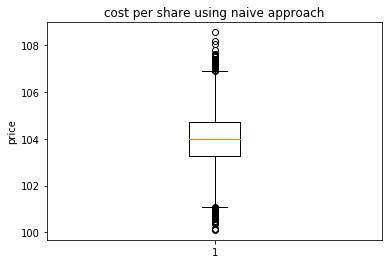

The median cost per share is $104.00


In [6]:
plt.boxplot(costs_per_share)
plt.title("cost per share using naive approach")
plt.ylabel("price")
plt.show()
print("The median cost per share is $%.2f" % np.median(costs_per_share))

As we can see from the graph above, the naive approach (splitting the sale of stock evenly among the 5 period, will incur a profit of \\$103.99 when we run 10000 trials on the same parameters, which is higher than the initial $P_0$ of \$100.

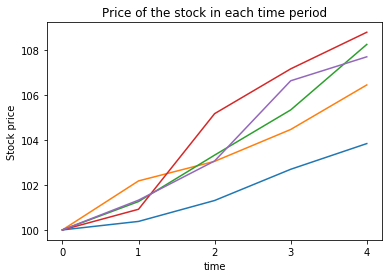

In [24]:
x = np.arange(0, 5)
y = np.asarray(Ps[0:5])
plt.plot(x, y.T)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Price of the stock in each time period")
plt.ylabel("Stock price")
plt.xlabel("time")
plt.show()


<br/>
<br/>
In the above cell we have plot 5 price changes over the stimuation time period (T=5) and we can see that when we split the purchase of the stock price evenly throughout the course of 5 time period the stock price goes down in each time period in expectation due to the linear price impact model. In those stimulations we can see that the effect of the price shock, or the error term, can sometimes upset the effect of the price impact of stock purchase and cause the stock price to go up.

### (2) Q-Learning on Linear Price Impact Model

In this section I will stimulate Q-Learning on the simple linear price impact model to find the optimal price execution strategy. In the literature, we are expected to see that the optimal price execution strategy is very similiar to that of naive approach of spliting the purchase evenly among all time period.

In this section, we will assume that the enviornment allows the order to be executed with certainty, thus making the transfer matrix of this problem **deterministic**. If time permits, we will also explore the problem where the order may not be fulfilled and thus making the transition matrix **stochastic**.

The **reward** for this problem is defined **dynamically**. The **reward** is the average price paid per share for the remaining time using optimal strategy compare to the current price.

$P_t = P_{t-1} + \epsilon_t + \theta S_t$

$R(S_{t,w}, A)$ means the action taken at time t with w remining dollar

$R(S_{t,w}, A)= $ number of stock sold $ *$  price of stock

This means that the lower the average cost of acquiring the share the higher the reward for taking the action will be.

The cell below is learning the Q-matrix by iterating through all the possible selling strategy within the time period (given that we can only sell in thousands and have 5 time period).

In [0]:
'''
inputs definition:
  total_shares is the total amount of shares we want to sell
  P_0 is the initial price
  T is the time period we want to sell the shares we have
  alpha is the constant for learning rate
  theta is the price impact constant
  gamma is the discount rate
  num_iter is the iteration we want to iterate through the possible paths
  
  price_func is a function that takes in the following inputs and output
    the price of stock at next time step
'''
def Q_learning(total_shares, P_0, T, alpha, theta, gamma, num_iter, price_func):
  
  start_time = datetime.datetime.now()

  # in each time step an agent can sell a multiple of 1000s of share of the stock
  # but at the end of T=10 the agent most have 5000 stocks sold
  actions = np.arange(0, int(total_shares / 1000 + 1))
  
  # the states are defined as time and the remining stock that we need to purchase
  # the columns index of the states indicates time and the row index of the states
  # indicates the amount remaining
  # states[i][j] means that at time i, there are j * 1000 shares remaind that
  # need to be purchased
  num_col = T
  num_row = total_shares // 1000 + 1
  states = np.zeros((num_col, num_row))

  # initilize the Q matrix, which has the dimension of
  # (num_states, num_actions) and num_states has shape of 
  # (T, total_shares // 1000) and num_actions = num_row
  Q = np.zeros((num_col, num_row, num_row))

  # R is a reward matrix that store the RUNNING AVERAGE reward
  # gathered by the trials
  R = np.zeros_like(Q)

  # counts is a matrix that keep track of the number of time
  # we have receive the reward at a point in R
  # this matrix is for bookkeeping for our RUNNING AVERAGE reward
  counts = np.zeros_like(R)

  num_iter = 1000

  # Q matrix update
  for i in range(num_iter):
      P_t = P_0

      # initial path: don't buy anything until the last time step
      # we will decrement the path backward until we reach a state where
      # we buy everything in the first time step
      # i.e. path[0] = 0
      path = [total_shares // 1000 for i in range(T)]
      # at the last time step the remaining shares to purchase must be 0
      path[-1] = 0

      # this variable is for path generation bookkeeping purpose
      # have another additional - 1 for indexing
      last_modified_time = (T - 1) - 1

      # iterate through each possible path
      while path[0] != -1:    
        # print("===== start of one path =======")
        last_nonzero_index = 0
        # print(path)

        P_t = P_0
        current_stocks_remaining = total_shares // 1000
        # iterate through each time period
        for t in range(T):
          stock_sold = current_stocks_remaining - path[t]
          reward_of_this_trial = stock_sold * P_t
          prev_average_reward = R[t][current_stocks_remaining][stock_sold]
          prev_counts = counts[t][current_stocks_remaining][stock_sold]

          reward = (reward_of_this_trial + prev_counts * prev_average_reward) \
            / (prev_counts + 1)

          R[t][current_stocks_remaining][stock_sold] = reward
          counts[t][current_stocks_remaining][stock_sold] += 1

          best_next_q = 0
          next_possible_actions = actions[:path[t]+1]
          # print(next_possible_actions)
          if t < T - 1:
            for next_action in next_possible_actions:
              best_next_q = max(best_next_q, Q[t+1][path[t]][next_action])

          # print(best_next_q)
          original_q = Q[t][current_stocks_remaining][stock_sold]
          Q[t][current_stocks_remaining][stock_sold] = original_q + \
                      alpha * (reward + gamma * best_next_q - original_q)

          current_stocks_remaining = path[t]

          # update price
          P_t = price_func(P_t, theta, stock_sold, path, t)

          # we sold all our stocks, time to run the next path
          if current_stocks_remaining == 0:
            last_nonzero_index = t - 1
            break

        if last_nonzero_index == -1:
          break

        # print(last_nonzero_index)
        # making new path
        path[last_nonzero_index] -= 1
        for t_to_change in range(last_nonzero_index + 1, T-1):
            path[t_to_change] = path[last_nonzero_index]
            
  end_time = datetime.datetime.now()
  time_diff = diff = relativedelta(end_time, start_time)
  print("The Q-learning for this problem takes %d hours %d minutes %d seconds to compute using Google Colab GPU" 
        % (time_diff.hours, time_diff.minutes, time_diff.seconds))
  return Q

    

In [9]:
# definnition of linear permanent price impact model
def linear_permanent_impact(current_price, theta, num_shares, path, t):
  noise = np.random.normal()
  next_price = current_price + noise + theta * num_shares * 1000
  return next_price

# learning rate
alpha = 0.9

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta = 2 * 10 ** -3

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

# number of iteration we want to go through with Q learning
num_iter = 1000

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 5 seconds to compute using Google Colab GPU


### (2.1) Translate Q-matrix to Optimal Selling Strategy

Now that we have learned a Q-matrix, let's define a method that will translate the Q-matrix into the optimal selling strategy. This is simple, as the optimal selling strategy (action) of a given state is just the argmax of the associated state in the Q-matrix (argmax over all the possible actions).

In [0]:
def Q_matrix_to_strategy(Q):
  
  total_time = len(Q)
  total_num_shares_to_sell = len(Q[0]) - 1
  print("====== Q-matrix analysis begin ======")
  print()
  print("Have {} time period to sell {},000 shares.\n"
        .format(total_time, total_num_shares_to_sell))
  print("Optimal strategy based on the learned Q-matrix:")
  num_stocks_left = total_shares // 1000
  for t in range(total_time):
    num_shares_to_sell = np.argmax(Q[t][num_stocks_left])
    print("at t={} sell {},000 shares"
          .format(t+1, num_shares_to_sell))
    num_stocks_left -= num_shares_to_sell
  
  print()
  print("====== Q-matrix analysis finish ======")

In [11]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 5,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the above cell's output, we see that our Q-learning algorithm does indeed find the same optimal strategy of selling share at equal amount at every time step! This finding reinforce further tell us that when the price impact is linear, the optimal strategy is to sell the same amount of shares at each time step!

### (2.2) Recover Theta, $\theta$, from the Q matrix

In this section we will define a method that helps us recover theta from the Q-matrix, assuming that the price impact model is linear and permanent.

In [0]:
# method that returns the recovered theta from Q-matrix computed earlier
# and the initial price of the stock we are trying to sell
def recover_theta_from_q_matrix(Q, P_0):
  total_time = len(Q)
  total_num_shares_to_sell = len(Q[0]) - 1
  num_shares = total_num_shares_to_sell * 1000
  
  best_total_profit = np.max(Q[0][total_num_shares_to_sell])
  initial_cost = P_0 * total_num_shares_to_sell
  profit_difference = best_total_profit - initial_cost
  recover_factor = 0.5 * total_time / total_num_shares_to_sell
  recovered_theta = profit_difference * recover_factor / num_shares
  return recovered_theta

In [0]:
# helper function to see how far we are off 
# from the recovered theta we found vs the real theta
def percentage_error(recovered_theta, theta):
  print("====== Recovered Theta Analysis Start ======\n")
  print("True Theta: {}".format(theta))
  print("Recovered Theta: {}".format(recovered_theta))
  diff = abs(recovered_theta - theta)
  error = diff / theta * 100
  print("Percentage Error: {0:.2f}%".format(error))
  print()
  print("====== Recovered Theta Analysis Ends ======")

In [14]:
recovered_theta = recover_theta_from_q_matrix(Q, P_0)
percentage_error(recovered_theta, theta)

====== Recovered Theta Analysis Start ======

True Theta: 0.002
Recovered Theta: 0.0019999180087742845
Percentage Error: 0.00%

====== Recovered Theta Analysis Ends ======


As we can see from the cell output above, we have successfully recovered the theta, $\theta$ from the Q-matrix that we computed before. The theta is unknown for us before but by analyizing the Q-matrix and do processing from values stored within the Q-matrix we are able to recover the unknown theta through Q-learning!

### (2.2) Test Our Q-Learning Model works with other settings

In this section, I want to further test our functionality of `Q_learning` and `Q_matrix_to_strategy` method that I have defined with other settings to make sure that I did not hard-code anything when I implment those methods.

In [199]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta = 2 * 10 ** -3

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 10000

# number of iteration we want to go through with Q learning
num_iter = 2

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 48 seconds to compute using Google Colab GPU


As we can see from the output of the cell above, when we increase the actions space (i.e. increase the total number of shares we can to sell) we increase the time to compute the Q-matrix exponentially. 

In [200]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 10,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 2,000 shares
at t=2 sell 2,000 shares
at t=3 sell 2,000 shares
at t=4 sell 2,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


As we can see from the output from the cell above, our Q-learning model is still able to learn the correct and optimal strategy of selling shares in equal amount through out the time period.

In [202]:
recovered_theta = recover_theta_from_q_matrix(Q, P_0)
percentage_error(recovered_theta, theta)

====== Recovered Theta Analysis Start ======

True Theta: 0.002
Recovered Theta: 0.0020019450819538293
Percentage Error: 0.10%

====== Recovered Theta Analysis Ends ======


As we can see from the output from the cell above, our Q-learning model is still able to learn the correct theta! Meaning that through looking at the value in Q-matrix we are able to recover the theta, which is the price impact, on selling the shares we own.

In [203]:
# learning rate
alpha = 0.9

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta = 2 * 10 ** -3

# time period of our model
T = 8

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 8000

# number of iteration we want to go through with Q learning
num_iter = 2

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 7 minutes 49 seconds to compute using Google Colab GPU


As we can see from above cell output, the time for my implmentation of Q-learning on this problem takes 7 minutes on GPU! As we can see that when we increase the time period T and total shares we want to sell, the time to compute the problem becomes long, but it still works! See the below cell output.

In [204]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 8 time period to sell 8,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares
at t=6 sell 1,000 shares
at t=7 sell 1,000 shares
at t=8 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output from above, our Q-learning model still able to come out with the optimal strategy in selling the shares we own even when it takes a long time to compute! 

### (2.3) Result of Using Q-learning on Linear Permanent Price Impact Model

As we can see from the above, the Q-learning algorithm is able to allow us to both find the optimal selling strategy (and with even more generalization to our algorithm we can also include the optimal buying strategy) and also learned the unknown theta. The resulting optimal strategy of Q-learning on linear permanent price impact model further proved that the best way to buy/sell a large number of shares is to split them equally throughout the time period that we have to trade the stock. For even in our first enviornment, the optimal strategy for selling 5,000 shares in 5 time period is to sell 1,000 shares at each time period.

### Lesson from this Project and Class

I really enjoy this completing this project. Throughout the project I learned techniques of not just about financial engineering but also about programming and machine learning in general. I learned about Q-learning, price impact models, reinforcement learning, general data synthesis and analysis. This project allows me to further digest the knowledge I learned in class by coding up the algorithm and stratgies. 


I also enjoy this class a lot. I really enjoy each lectures and sections as I learned new and chellenging materials each time I walked into class. I really enjoyed the theorical and mathematics concepts taught by Professor Basei and the high frequency trading application taught by Professor Guo. I really appreciate Nan for hosting section each week to clear up any hard to digest concepts taught by professors in class.


Once again, I want to say thank you to Professor Guo, Professor Basei, and Nan for teaching me a lot about financial engineering and high frequency trading through IEOR 221 and IEOR 222.



